In [9]:
import os
import subprocess
import signal
import time
import threading
import rosbag
import matplotlib.pyplot as plt
import pandas as pd

## Functions

### ROS Functions

In [53]:
roscore_process = None

def start_roscore():
    global roscore_process
    try:
        # Check if roscore is running
        output = subprocess.check_output(["rosnode", "list"])
        print("roscore is already running.")
    except subprocess.CalledProcessError:
        # Start roscore if not running
        print("Starting roscore...")
        roscore_process = subprocess.Popen(["roscore"], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
        time.sleep(3)  # Give roscore some time to start

def stop_roscore():
    global roscore_process
    if roscore_process is not None:
        print("Stopping roscore...")
        roscore_process.send_signal(signal.SIGINT)
        roscore_process.wait()
        roscore_process = None

def run_rosbag(file):
    start_roscore()
    print(f"Playing rosbag: {file}")
    cmd = ["rosbag", "play", file]
    process = subprocess.Popen(cmd)
    try:
        process.wait()
    except KeyboardInterrupt:
        process.send_signal(signal.SIGINT)
        process.wait()
    print("Rosbag finished.")

def plot_rosbag_activity(file, topics=None):
    # Read the bag
    bag = rosbag.Bag(file)
    all_topics = bag.get_type_and_topic_info().topics.keys()
    
    if topics is None:
        topics = all_topics
        print(f"Using all topics available: {topics}")
    
    timestamps = {topic: [] for topic in topics}

    for topic, msg, t in bag.read_messages(topics=topics):
        timestamps[topic].append(t.to_sec())

    bag.close()

    # Create plot
    n_subplots = len(topics)
    fig, axs = plt.subplots(n_subplots, 1, figsize=(10, n_subplots * 0.8), sharex=True)
    
    if n_subplots == 1:
        axs = [axs]  # Ensure axs is iterable even for one subplot
    
    for i, topic in enumerate(topics):
        times = timestamps.get(topic, [])
        if times:
            axs[i].plot(times, [1] * len(times), '|', markersize=10)
        axs[i].set_yticks([])
        axs[i].set_ylabel(topic)
        axs[i].legend([topic])
    
    bag_name = os.path.basename(file)
    fig.suptitle(f"ROS Bag Activity: {bag_name}", fontsize=16)
    plt.xlabel("Timestamp (s)")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

### Pandas DF Functions

In [36]:
def create_df(filepath, save=False):
    """Create a pandas DataFrame from a ROS bag file."""
    # Check if pkl already exists
    if save==True and os.path.exists(os.path.join('data', 'pkl',
                                     os.path.splitext(os.path.basename(filepath))[0] + '.pkl')):
        print(f'File exists, skipping {os.path.splitext(os.path.basename(filepath))[0]}')
        return

    bag = rosbag.Bag(filepath)
    data = []
    
    for topic, msg, t in bag.read_messages():
        # Convert message to dictionary
        msg_dict = {'topic': topic, 'timestamp': t.to_sec()}
        # Flatten message fields into dictionary
        msg_dict.update({slot: getattr(msg, slot) for slot in msg.__slots__})
        data.append(msg_dict)
    
    bag.close()
    
    # Create dataframe
    df = pd.DataFrame(data)
    
    if save:
        save_df_as_pkl(df, filepath)
    
    return df

def save_df_as_pkl(df, filepath):
    """Save pandas DataFrame to a pickle file."""
    bag_name = os.path.splitext(os.path.basename(filepath))[0]
    output_dir = os.path.join('data', 'pkl')
    os.makedirs(output_dir, exist_ok=True)
    
    pkl_path = os.path.join(output_dir, f"{bag_name}.pkl")
    df.to_pickle(pkl_path)
    print(f"Saved dataframe to {pkl_path}")

def read_pkl(filepath):
    """Read a pickle file and return a pandas DataFrame."""
    df = pd.read_pickle(filepath)
    return df

def plot_df_activity(df, cols=None):
    """Plot activity from DataFrame similar to ROS bag activity."""
    if cols is None:
        cols = df.columns
    
    timestamps = {col: [] for col in cols}

    for _, row in df.iterrows():
        for col in cols:
            if not pd.isna(row[col]):
                timestamps[col].append(row['timestamp'])

    n_subplots = len(cols)
    fig, axs = plt.subplots(n_subplots, 1, figsize=(12, n_subplots * 2), sharex=True)
    
    if n_subplots == 1:
        axs = [axs]  # Ensure axs is iterable even for one subplot
    
    for i, col in enumerate(cols):
        times = timestamps.get(col, [])
        if times:
            axs[i].plot(times, [1] * len(times), '|', markersize=10)
        axs[i].set_yticks([])
        axs[i].set_ylabel(col)
        axs[i].legend([col])
    
    fig.suptitle("DataFrame Activity", fontsize=16)
    plt.xlabel("Timestamp (s)")
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

## Create ROS Bags as pkl files (=Pandas DF)

In [37]:
directory = 'data/'

### Get Directories of ROS Bags

In [50]:
# Recursively search directory for all files with .bag ending and append to list
dirs = []
for root, subdirs, files in os.walk(directory):
    for file in files:
        if file.endswith('.bag'):
            dirs.append(os.path.join(root, file))

### Save ROS Bag to Pandas DF

In [56]:
for file in dirs:
    create_df(file, save=True)
    break

Saved dataframe to data/pkl/ReturnHome_forwards_slowly_level_2025-03-13-16-57-11.pkl


### Plot ROS Bag

Using all topics available: dict_keys(['/ImuFilterNodelet/parameter_descriptions', '/ImuFilterNodelet/parameter_updates', '/imu/data', '/imu/data_raw', '/imu/gyro_offset', '/imu/trigger', '/radar/cfar_detections', '/radar/ls_velocity', '/radar/trigger', '/radar/vrpn_client/estimated_odometry', '/radar/vrpn_client/estimated_transform', '/radar/vrpn_client/raw_transform', '/radar/vrpn_client/vicon_intermediate_results', '/rosout', '/rosout_agg', '/sensors_nodelet_manager/bond', '/tf', '/tf_static', '/zadar/clusters0', '/zadar/imu0', '/zadar/odometry0', '/zadar/scan0', '/zadar/tracks0'])


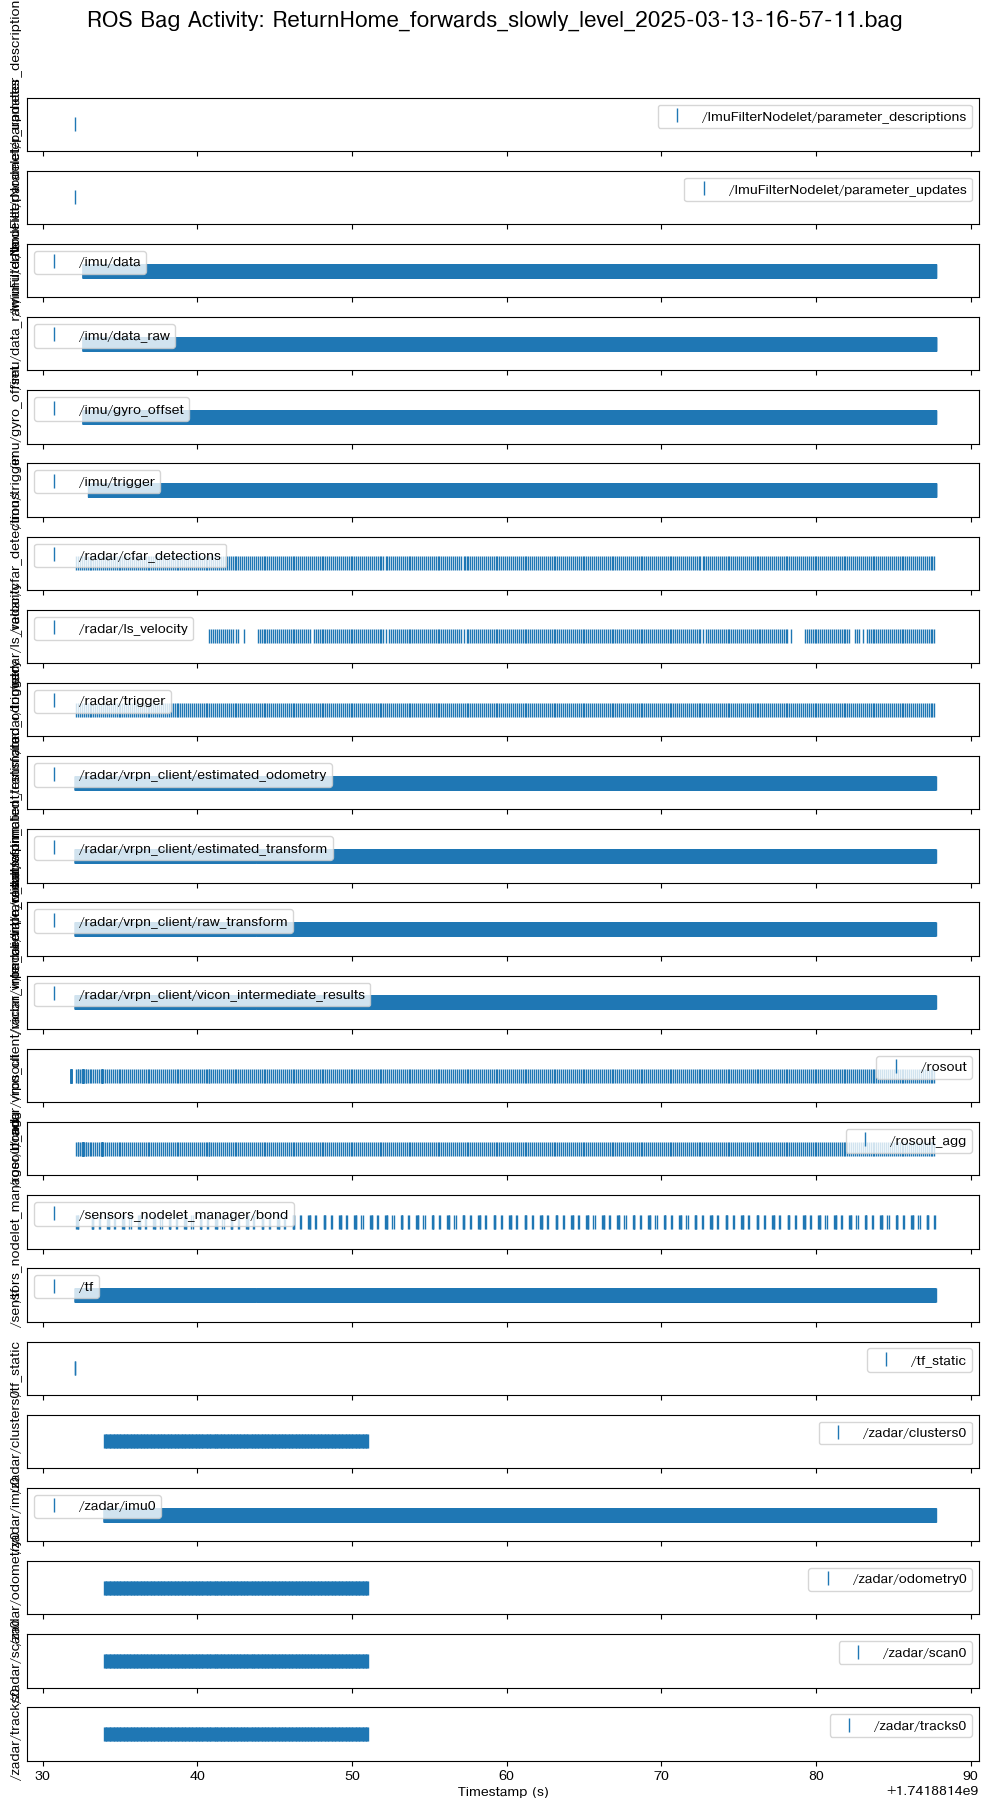

Using all topics available: dict_keys(['/ImuFilterNodelet/parameter_descriptions', '/ImuFilterNodelet/parameter_updates', '/imu/data', '/imu/data_raw', '/imu/gyro_offset', '/imu/trigger', '/radar/cfar_detections', '/radar/ls_velocity', '/radar/trigger', '/radar/vrpn_client/estimated_odometry', '/radar/vrpn_client/estimated_transform', '/radar/vrpn_client/raw_transform', '/radar/vrpn_client/vicon_intermediate_results', '/rosout', '/rosout_agg', '/sensors_nodelet_manager/bond', '/tf', '/tf_static', '/zadar/clusters0', '/zadar/imu0', '/zadar/odometry0', '/zadar/scan0', '/zadar/tracks0'])


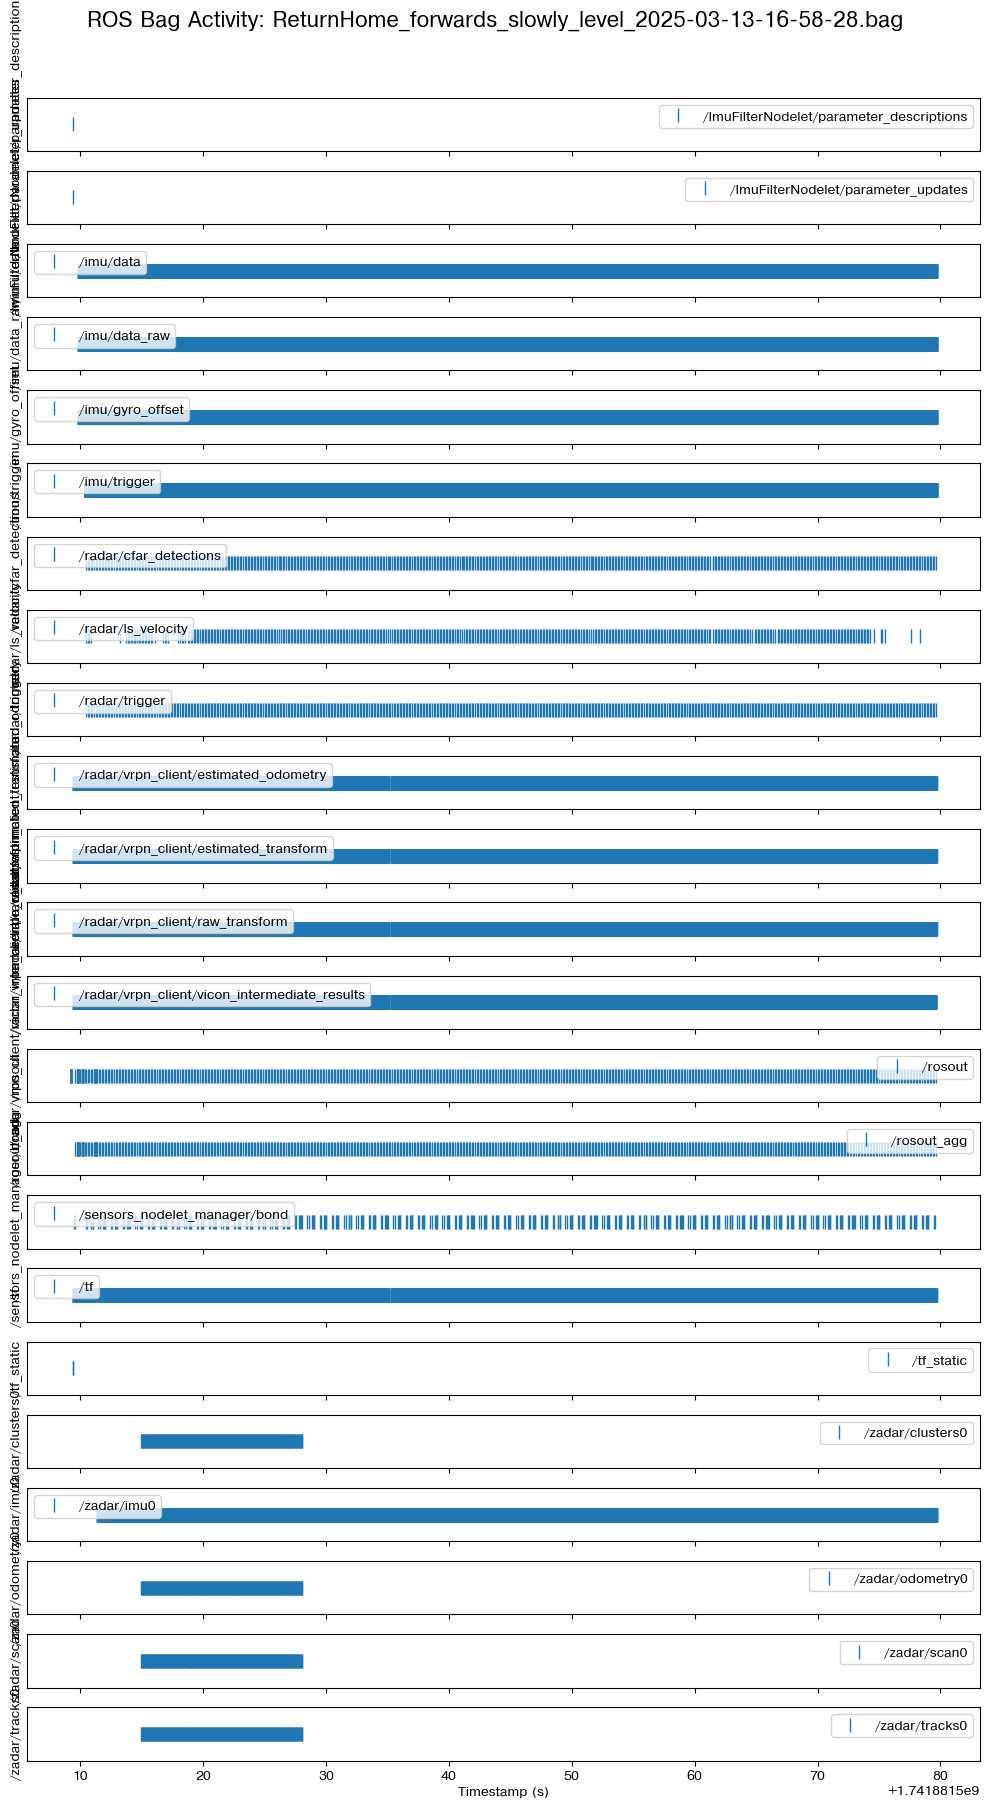

Using all topics available: dict_keys(['/ImuFilterNodelet/parameter_descriptions', '/ImuFilterNodelet/parameter_updates', '/imu/data', '/imu/data_raw', '/imu/gyro_offset', '/imu/trigger', '/radar/cfar_detections', '/radar/ls_velocity', '/radar/trigger', '/radar/vrpn_client/estimated_odometry', '/radar/vrpn_client/estimated_transform', '/radar/vrpn_client/raw_transform', '/radar/vrpn_client/vicon_intermediate_results', '/rosout', '/rosout_agg', '/sensors_nodelet_manager/bond', '/tf', '/tf_static', '/zadar/clusters0', '/zadar/imu0', '/zadar/odometry0', '/zadar/scan0', '/zadar/tracks0'])


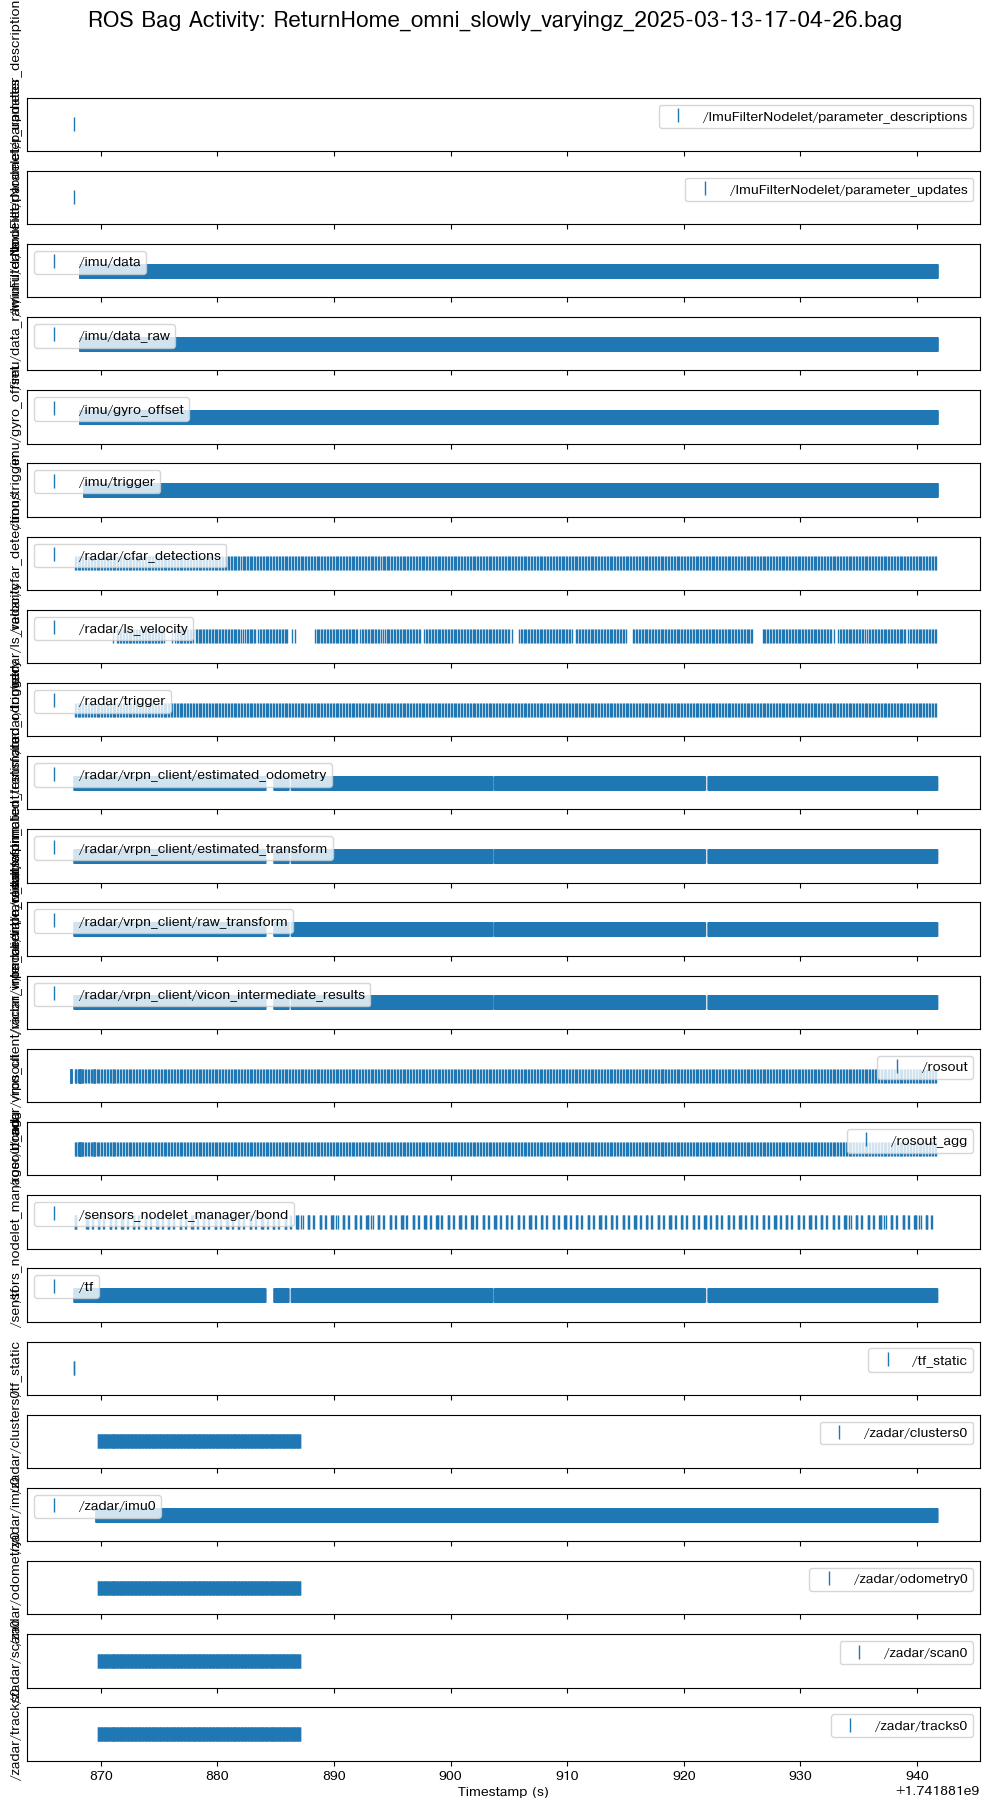

Using all topics available: dict_keys(['/ImuFilterNodelet/parameter_descriptions', '/ImuFilterNodelet/parameter_updates', '/imu/data', '/imu/data_raw', '/imu/gyro_offset', '/imu/trigger', '/radar/cfar_detections', '/radar/ls_velocity', '/radar/trigger', '/radar/vrpn_client/estimated_odometry', '/radar/vrpn_client/estimated_transform', '/radar/vrpn_client/raw_transform', '/radar/vrpn_client/vicon_intermediate_results', '/rosout', '/rosout_agg', '/sensors_nodelet_manager/bond', '/tf', '/tf_static', '/zadar/clusters0', '/zadar/imu0', '/zadar/odometry0', '/zadar/scan0', '/zadar/tracks0'])


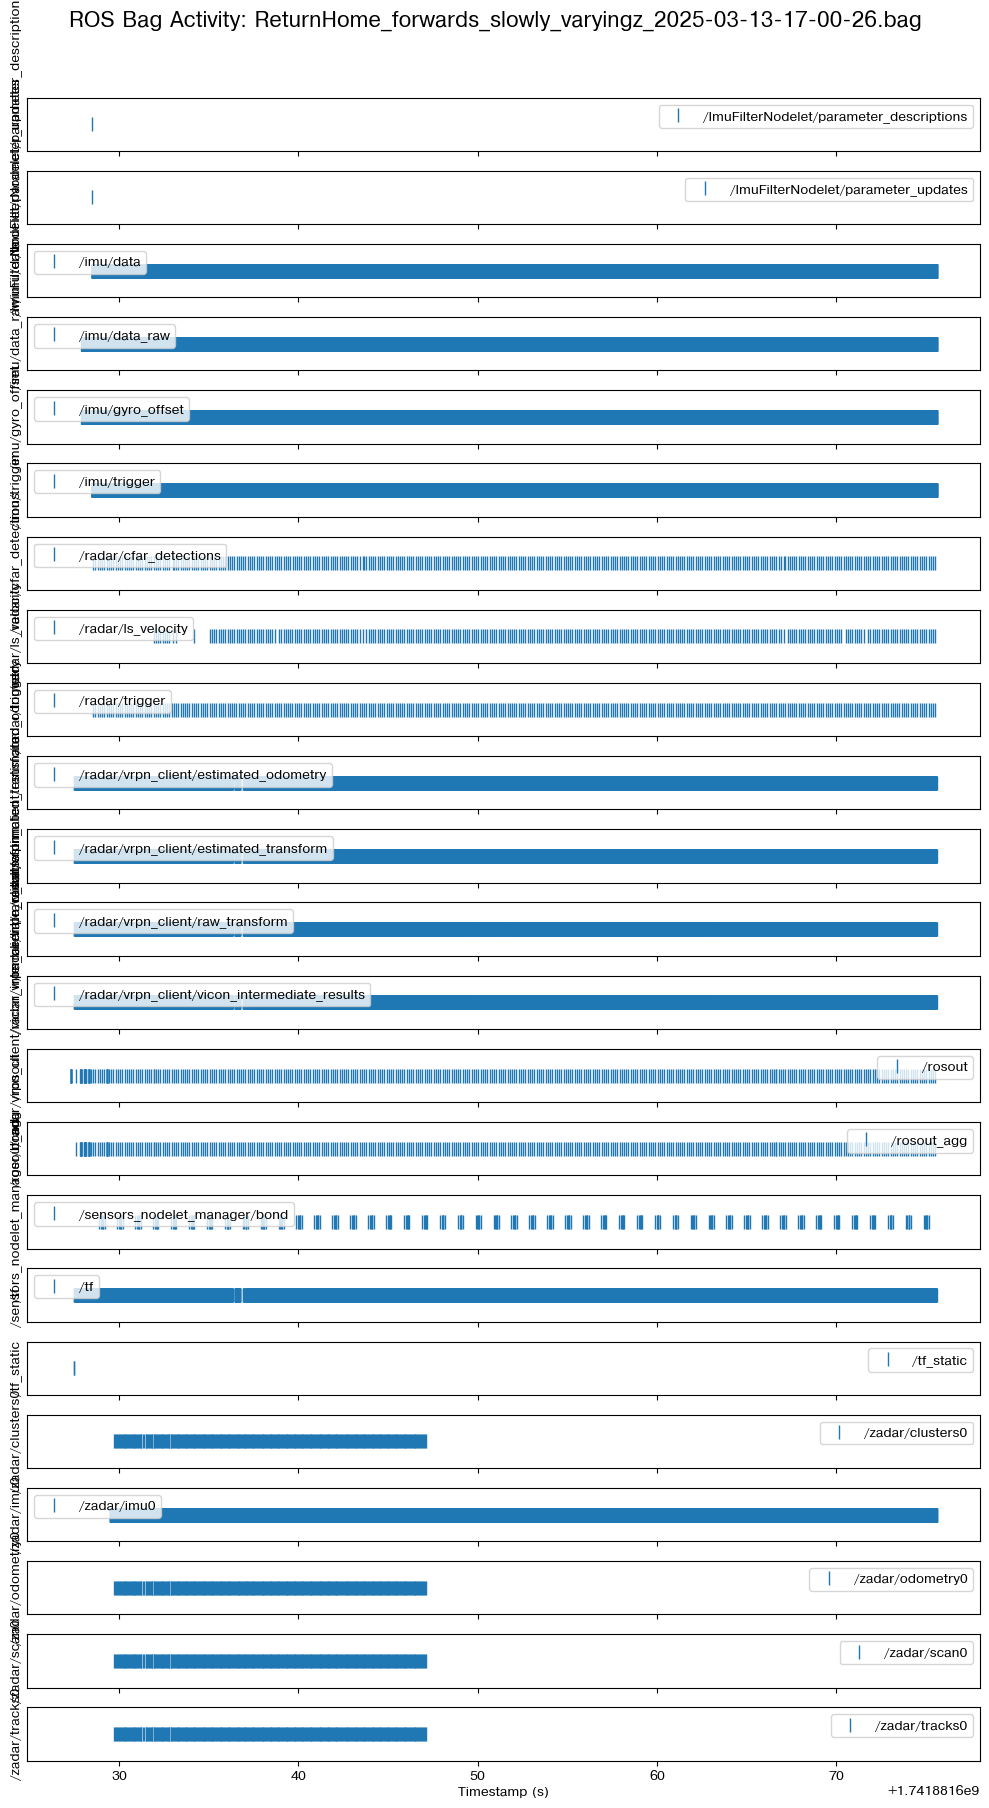

Using all topics available: dict_keys(['/ImuFilterNodelet/parameter_descriptions', '/ImuFilterNodelet/parameter_updates', '/imu/data', '/imu/data_raw', '/imu/gyro_offset', '/imu/trigger', '/radar/cfar_detections', '/radar/ls_velocity', '/radar/trigger', '/radar/vrpn_client/estimated_odometry', '/radar/vrpn_client/estimated_transform', '/radar/vrpn_client/raw_transform', '/radar/vrpn_client/vicon_intermediate_results', '/rosout', '/rosout_agg', '/sensors_nodelet_manager/bond', '/tf', '/tf_static', '/zadar/clusters0', '/zadar/imu0', '/zadar/odometry0', '/zadar/scan0', '/zadar/tracks0'])


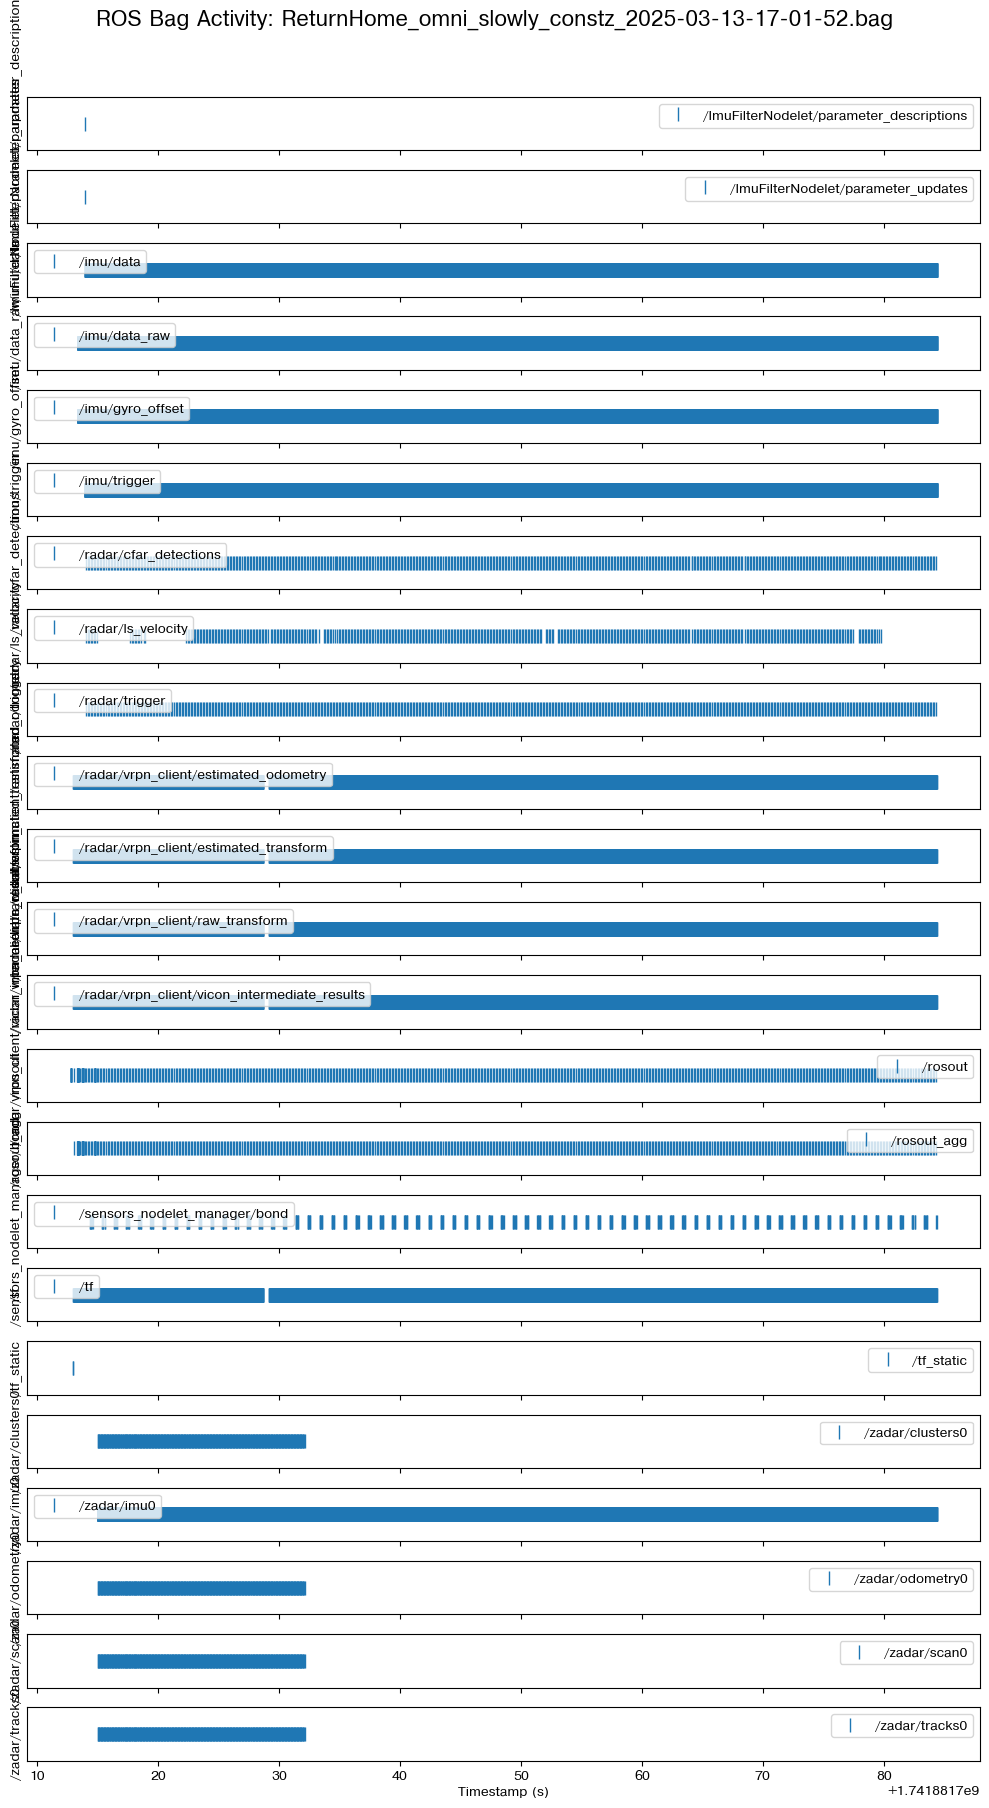

In [54]:
for file in dirs:
    plot_rosbag_activity(file)

## Plot Pandas DF (=pkl files)

In [46]:
df_paths = []
substring = ''

for root, subdirs, files in os.walk(os.path.join('data', 'pkl')):
    for file in files:
        if substring in file:
            df_paths.append(os.path.join(root, file))

print(df_paths)

['data/pkl/ReturnHome_forwards_slowly_level_2025-03-13-16-57-11.pkl', 'data/pkl/ReturnHome_forwards_slowly_level_2025-03-13-16-58-28.pkl', 'data/pkl/ReturnHome_forwards_slowly_varyingz_2025-03-13-17-00-26.pkl', 'data/pkl/ReturnHome_omni_slowly_constz_2025-03-13-17-01-52.pkl', 'data/pkl/ReturnHome_omni_slowly_varyingz_2025-03-13-17-04-26.pkl']


In [49]:
for df_path in df_paths:
    df = read_pkl(df_path)
    # plot_df_activity(df)
    break